In [1]:
import cv2
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image, ImageDraw
from shapely.geometry import Polygon
from ultralytics import YOLO

In [41]:
def get_list_from_xywh(bb:list):
    return [[int(bb[0]), int(bb[1])],
            [int(bb[2]), int(bb[1])],
            [int(bb[0]), int(bb[3])],
            [int(bb[2]), int(bb[3])]]

def format_swap(bbx:list):
    bbx_1 = get_list_from_xywh(bbx)
    bbx_1_tmp = bbx_1[-1]
    bbx_1[-1] = bbx_1[-2]
    bbx_1[-2] = bbx_1_tmp
    return bbx_1


def calculate_int(human: list, zone: list, draw=False):
    square = (human[2] - human[0]) * (human[3] - human[1])
    # Человека перевожим в координаты
    human = format_swap(human) # Пусть это будет человек
    # Зону просто парсим

    poly_1 = Polygon(human)
    poly_2 = Polygon(zone)
    # print("Процент вхождения человека в зону")
    if draw:
      plt.plot(*poly_1.exterior.xy)
      plt.plot(*poly_2.exterior.xy)
    return (poly_1.intersection(poly_2).area / square) * 100


def draw_by_points(img, zone: list, color=(255, 0, 0),
                   thick=5):
  zone.append(zone[0])
  for p in range(len(zone) - 1):
    cv2.line(img,
             (zone[p][0], zone[p][1]),
             (zone[p + 1][0], zone[p + 1][1]),
             color,
             thick)

  return img

In [72]:
model = YOLO("runs/detect/train22/weights/best.pt")
# model = YOLO("detect/train2/weights/best.pt")
image_file = r"D:\Study\Hack_10.11.2023\cameras\DpR-Csp-uipv-ShV-V1\1a16321d-4371-4721-bbc9-ccfc4a17687c.jpg"
a = model(image_file)
a
if a[0].boxes.xyxy.tolist():
    humans = a[0].boxes.xyxy.tolist()
else:
    humans = []

print(humans)


image 1/1 D:\Study\Hack_10.11.2023\cameras\DpR-Csp-uipv-ShV-V1\1a16321d-4371-4721-bbc9-ccfc4a17687c.jpg: 384x640 2 persons, 287.6ms
Speed: 4.0ms preprocess, 287.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


[[772.1956787109375, 305.4487609863281, 916.7852783203125, 523.6453857421875], [1459.5400390625, 296.6908264160156, 1559.41455078125, 436.5301208496094]]


In [65]:
a[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.8319])
data: tensor([[7.4353e+02, 4.1552e+02, 9.5405e+02, 9.7239e+02, 8.3189e-01, 0.0000e+00]])
id: None
is_track: False
orig_shape: (1080, 1920)
shape: torch.Size([1, 6])
xywh: tensor([[848.7907, 693.9530, 210.5215, 556.8675]])
xywhn: tensor([[0.4421, 0.6425, 0.1096, 0.5156]])
xyxy: tensor([[743.5300, 415.5192, 954.0515, 972.3867]])
xyxyn: tensor([[0.3873, 0.3847, 0.4969, 0.9004]])

In [61]:
import os

arr = image_file.split("\\")

cameras_index = arr.index("cameras")
dir_path = image_file.split("cameras")[0]


zone_path = os.path.join(dir_path, "danger_zones", f"danger_{arr[cameras_index+1]}.txt")

zone = []
with open(zone_path) as file:
    for line in file:      
        string = line.replace(",", "")
        string = string.replace("[", "")
        string = string.replace("]", "")
        string = string.strip()
        zone.append([int(string.split(" ")[0]), int(string.split(" ")[1])])
zone

[[1036, 831], [480, 475], [614, 421], [1171, 691]]

In [73]:
humans

[[772.1956787109375, 305.4487609863281, 916.7852783203125, 523.6453857421875],
 [1459.5400390625, 296.6908264160156, 1559.41455078125, 436.5301208496094]]

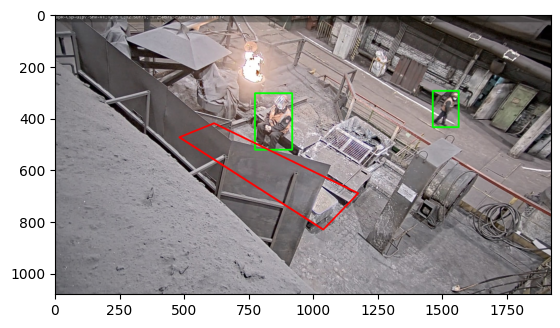

In [75]:
import cv2
import matplotlib.pyplot as plt

b = cv2.imread(image_file)
b = cv2.cvtColor(b, cv2.COLOR_BGR2RGB)

for i in humans:
    b = cv2.rectangle(b, (int(i[0]), int(i[1])), (int(i[2]), int(i[3])), (0, 255, 0), 5)
b = draw_by_points(b, zone)
plt.imshow(b);


'Процент вхождения человека в зону: 0.0%'

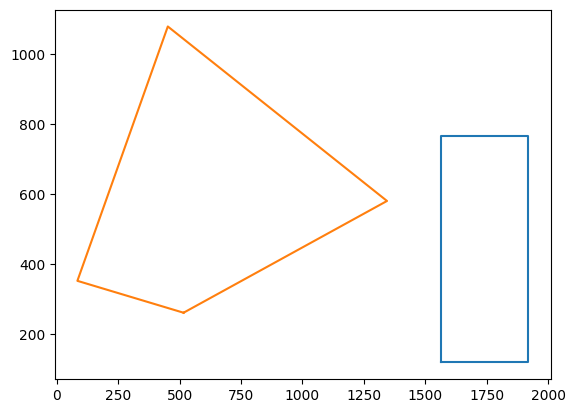

In [50]:
f"Процент вхождения человека в зону: {round(calculate_int(human, zone, draw=True), 2)}%"

In [94]:
from ensemble_boxes import weighted_boxes_fusion


def compute_metrics(boxes, confidences, weights, iou_thr=0.5, skip_box_thr=0.001):
    """
    Computes WBF metrics for bounding boxes and confidences
    """
    labels = [[0 for _ in range(len(conf))] for conf in confidences]
    res = weighted_boxes_fusion(boxes, confidences, labels,
                                weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    return [res[0].tolist(), res[1].tolist()]


In [100]:
boxes = []
confidences = []

In [101]:
yolob8n = YOLO("YOLOv8n.pt")
# model = YOLO("detect/train2/weights/best.pt")
image_file = r"D:\Study\Hack_10.11.2023\cameras\DpR-Csp-uipv-ShV-V1\1a16321d-4371-4721-bbc9-ccfc4a17687c.jpg"
a = yolob8n(image_file)
if a[0].boxes.xyxyn.tolist():
    humans = a[0].boxes.xyxyn.tolist()
    confs = a[0].boxes.conf.tolist()
else:
    humans = []
    confs = []
    
boxes.append(humans)
confidences.append(confs)
print(humans)


image 1/1 D:\Study\Hack_10.11.2023\cameras\DpR-Csp-uipv-ShV-V1\1a16321d-4371-4721-bbc9-ccfc4a17687c.jpg: 384x640 2 persons, 201.6ms
Speed: 4.5ms preprocess, 201.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


[[0.40218526124954224, 0.28282293677330017, 0.4774923324584961, 0.48485684394836426], [0.7601770758628845, 0.2747137248516083, 0.8121950626373291, 0.40419456362724304]]


In [81]:
a[0].boxes.conf.tolist()

[0.8436354398727417, 0.8170313835144043]

In [102]:
yolob8m = YOLO("YOLOv8m.pt")
image_file = r"D:\Study\Hack_10.11.2023\cameras\DpR-Csp-uipv-ShV-V1\1a16321d-4371-4721-bbc9-ccfc4a17687c.jpg"
a = yolob8m(image_file)
if a[0].boxes.xyxyn.tolist():
    humans = a[0].boxes.xyxyn.tolist()
    confs = a[0].boxes.conf.tolist()
else:
    humans = []
    confs = []
    
boxes.append(humans)
confidences.append(confs)
print(humans)


image 1/1 D:\Study\Hack_10.11.2023\cameras\DpR-Csp-uipv-ShV-V1\1a16321d-4371-4721-bbc9-ccfc4a17687c.jpg: 384x640 2 persons, 950.6ms
Speed: 3.0ms preprocess, 950.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


[[0.39717429876327515, 0.2843461036682129, 0.4773775339126587, 0.4818071722984314], [0.7613856196403503, 0.2734214663505554, 0.8122507929801941, 0.401735782623291]]


In [104]:
a[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0., 0.])
conf: tensor([0.8908, 0.8357])
data: tensor([[7.6257e+02, 3.0709e+02, 9.1656e+02, 5.2035e+02, 8.9078e-01, 0.0000e+00],
        [1.4619e+03, 2.9530e+02, 1.5595e+03, 4.3387e+02, 8.3574e-01, 0.0000e+00]])
id: None
is_track: False
orig_shape: (1080, 1920)
shape: torch.Size([2, 6])
xywh: tensor([[ 839.5698,  413.7228,  153.9902,  213.2580],
        [1510.6909,  364.5849,   97.6611,  138.5794]])
xywhn: tensor([[0.4373, 0.3831, 0.0802, 0.1975],
        [0.7868, 0.3376, 0.0509, 0.1283]])
xyxy: tensor([[ 762.5746,  307.0938,  916.5649,  520.3517],
        [1461.8604,  295.2952, 1559.5215,  433.8746]])
xyxyn: tensor([[0.3972, 0.2843, 0.4774, 0.4818],
        [0.7614, 0.2734, 0.8123, 0.4017]])

In [91]:
boxes

[[[772.1956787109375, 305.4487609863281, 916.7852783203125, 523.6453857421875],
  [1459.5400390625, 296.6908264160156, 1559.41455078125, 436.5301208496094]],
 [[762.5746459960938, 307.0937805175781, 916.5648803710938, 520.3517456054688],
  [1461.8603515625, 295.2951965332031, 1559.521484375, 433.8746337890625]]]

In [98]:
confidences

[[0.8436354398727417, 0.8170313835144043],
 [0.8907824754714966, 0.8357441425323486]]

In [103]:
compute_metrics(boxes, confidences, weights=(1, 3))

[[[0.3983766436576843,
   0.2839806377887726,
   0.47740504145622253,
   0.4825389087200165],
  [0.7610886096954346,
   0.2737390697002411,
   0.8122370839118958,
   0.4023400843143463]],
 [0.8789957165718079, 0.8310659527778625]]

In [ ]:
image_file